# Mill Exploratory Data Analysis

My primary deck at the moment, and inspiration for this project, is Mill. While most decks seek to win by setting the opponent's life total to 0 from the starting value of 20, Mill seeks to remove all of the cards in a player's library by putting them in the graveyard (or exiling them) and then winning by rule 121.4, which states that *"A player who attempts to draw a card from a library with no cards in it loses the game the next time a player would receive priority."* I will be focusing on the modern format for this notebook.

## Import Libraries

In [1]:
%matplotlib inline

import os
import math

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import json

## Import Datasets

The needed datasets might change depending on the cards and lines that need testing.

In [2]:
DIR_PATH_CARDS = os.path.join(os.getcwd(), "data", "clean_data")
DIR_PATH_DECKS = os.path.join(os.getcwd(), "data", "tournament_deck_lists")

In [3]:
Cards = pd.read_csv(os.path.join(DIR_PATH_CARDS, "Cards.csv"))
CardsCost = pd.read_csv(os.path.join(DIR_PATH_CARDS, "CardsCost.csv"))
CardsLegality = pd.read_csv(os.path.join(DIR_PATH_CARDS, "CardsLegality.csv"))
CardsPrintings = pd.read_csv(os.path.join(DIR_PATH_CARDS, "CardsPrintings.csv"))
CardsTypes = pd.read_csv(os.path.join(DIR_PATH_CARDS, "CardsTypes.csv"))

In [4]:
Mainboard = pd.read_csv(os.path.join(DIR_PATH_DECKS, "Mainboard.csv"))
Mainboard = Mainboard.loc[:, ~Mainboard.columns.str.contains('^Unnamed')][:-2]

Sideboard = pd.read_csv(os.path.join(DIR_PATH_DECKS, "Sideboard.csv"))
Sideboard = Sideboard.loc[:, ~Sideboard.columns.str.contains('^Unnamed')][:-2]

Companion = pd.read_csv(os.path.join(DIR_PATH_DECKS, "Companion.csv"))
Companion = Companion.loc[:, ~Companion.columns.str.contains('^Unnamed')][:-2]

Statistics = pd.read_csv(os.path.join(DIR_PATH_DECKS, "Statistics.csv"))
Statistics = Statistics.loc[:, ~Statistics.columns.str.contains('^Unnamed')][:-1]

# Card Testing

Specific cards that need testing are as follows:

* **Tasha's Hideous Laughter**: This card exiles cards from the top of each opponent's library depending on the converted mana cost (cmc) of exiled cards. A very common card in Modern Mill decks.
* **Sanity Grinding**: This card depends on the number of Blue mana symbols on cards of your library. While not commonly played, there are enough blue value cards in the deck to give this card a look.
* **Mind Funeral**: This card mills cards until 4 land cards are removed from the target player's library. This card is not commonly played and I do not expect great value on this, but I still believe that it is worth a look.
* **Hedron Crab** and **Ruin Crab**: These two cards are functionally the same and provide value over time, and I believe it would be a good idea to understand the value of these *Creature* cards based on turn played and how long it remains on the field.

I also want to take a look at expected mill value per 1 cmc in the deck. While one would expect it to be okay for one card to mill half the cards of a spell with double the CMC, there is a balance that needs to be struck. If a card costs too much, it could be too slow for this deck to operate competitively, but if two cards need to be cast to match the value of a single card, you are more making the deck less efficient.

However, the important part of these calculations is using tournament decks to determine worth, considering these are widely held as the top constructions of decks and are more likely to be encountered.

# Tasha's Hideous Laughter

![Each opponent exiles cards from the top of their library until that player has exiled cards with total mana value 20 or more.](http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=527365&type=card)
![Fractured Sanity](http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=567539&type=card)

This card is a gambler's dream, considering this card can either have great or poor value. At three mana to cast, the closest comparison to this card is Fractured Sanity, a card which mills 14 cards for the same converted mana cost. The added benefit from Tasha's is that it exiles the milled cards rather than putting them into the graveyard, thus helping the deck against "shuffle" effects which return a graveyard to the owner's library. However, Fractured Sanity has a "Cycle" effect, which allows the player to draw a card in its place, thus giving the player a chance to replace this card with another card that might be more useful in the moment.

As a result, it is desired to see Tasha's milling approximately the same number of cards as Fractured Sanity or more.

## Method

First, each deck will be grouped along with what cards appear on tournament lists. MTG Goldfish provides a meta share for the cards seen in the deck type. This can be used to construct a representation of the potential deck seen based on the overall average presence of the card. While not perfectly representing the deck, this should account for random variations appearing based on player preference. Information gained during the match, should largely determine sideboarding along with the "Overall" graph below.

Second, each card that is present in at least one version of the deck will multiplied by its Converted Mana Cost (CMC), which is the total mana value of the card. This will allow the average mana cost of the card to found and applied. On average, this value will be representative of one card in the deck, and thus the number of times this value goes into 20, should be the average milled cards by Tasha's Hideous Laughter.

Third, the maximum and minimum cards able be milled will be found. This will be done by taking the 0 mana value cards out of the deck. This value will be added on top of the average remaining cmc (subtracting 3 from this value to represent the opponent playing three lands) to represent the maximum cards milled, while the average remaining cmc will be used on its own to represent the minimum number of milled cards. The intention is to switch this to standard deviations, so that the value of Tasha's Hideous Laughter is more apparent.

### Consolidate Lists and Find Deck Sizes

In [5]:
Mainboard.fillna(0, inplace=True)
Sideboard.fillna(0, inplace=True)

In [6]:
# All Dataframes should have the same number of decktypes and can be pulled from a single column list
deck_types = list(Mainboard['title'].unique())

In [7]:
# Average deck size according to taken mean of each card's prevalence
mainboard_deck_size = {}
for deck in deck_types:
    mainboard_deck_size[deck] = Mainboard[Mainboard.title == deck].drop("title", inplace=False, axis=1).dropna().sum(axis=1)

In [8]:
# Average side board size according to taken mean of each card's prevalence
sideboard_deck_size = {}
for deck in deck_types:
    sideboard_deck_size[deck] = Sideboard[Sideboard.title == deck].drop("title", inplace=False, axis=1).dropna().sum(axis=1)

In [9]:
# Set Archetype Title to Index, for ease of use
Mainboard.set_index("title", inplace=True)
Sideboard.set_index("title", inplace=True)

In [10]:
# Combining Sideboard and Mainboard Piles (a common strategy is to not remain at a 60 card deck when sideboarding against mill)
Overall = Mainboard.add(Sideboard, fill_value=0)

In [11]:
# Average overall card count according to taken mean of each card's prevalence
overall_deck_size = {}
for deck in deck_types:
    overall_deck_size[deck] = Overall[Overall.index==deck].dropna().sum(axis=1).values[0]

### Apply the CMC for Each Card

In [12]:
# Reduced dataframe for speed
CardCMC = Cards[['name', 'cmc']]

In [13]:
import requests
from requests.auth import HTTPDigestAuth
import json
import time

def scryfall_search(card_name: str):
  # Replace with the correct URL
  url = "https://api.scryfall.com/cards/named?fuzzy=" + card_name.replace(" ", "+")

  # It is a good practice not to hardcode the credentials. So ask the user to enter credentials at runtime
  myResponse = requests.get(url, verify=True)
  #print (myResponse.status_code)
  time.sleep(0.5)

  # For successful API call, response code will be 200 (OK)
  if(myResponse.ok):
    
    # Loading the response data into a dict variable
    # json.loads takes in only binary or string variables so using content to fetch binary content
    # Loads (Load String) takes a Json file and converts into python data structure (dict or list, depending on JSON)
    jData = json.loads(myResponse.content)
    return json.loads(myResponse.content.decode('utf-8'))["cmc"]
  else:
    # If response code is not ok (200), print the resulting http error code with description
    myResponse.raise_for_status()
    raise PermissionError(f"Call to Scryfall failed for {card_name}")

In [14]:
# Applies the cmc value to the prevalence of each card to appropriately calculate the cmc contribution
mainboard_mean_cmc = []
sideboard_mean_cmc = []
overall_mean_cmc = []

# Stores cards cmc values for speed and reduced computer load
leftover_cmc = {}

for deck in deck_types:
    mainboard_temp = Mainboard.loc[deck].dropna(axis=0)
    sideboard_temp = Sideboard.loc[deck].dropna(axis=0)
    overall_temp = Overall.loc[deck].dropna(axis=0)

    missing_cards = []

    for card in list(mainboard_temp.index):
        # Handle split cards
        if "/" in card:
            card_alt = card.split(" / ")[0].strip(" ")
            card_printings_cmcs = CardCMC[CardCMC.name==card_alt]['cmc'].values
        else:
            card_printings_cmcs = CardCMC[CardCMC.name==card]['cmc'].values
        # Handle cards in Cards database
        if len(card_printings_cmcs) > 0:
            cmc = card_printings_cmcs[0]
            mainboard_temp[card] = mainboard_temp[card] * cmc
            leftover_cmc[card] = cmc
        # Handle cards not in Cards database due to error or outdated source API
        else:
            if card in list(leftover_cmc.keys()):
                cmc = leftover_cmc[card]
                mainboard_temp[card] = mainboard_temp[card] * cmc
            else:
                #missing_cards.append(card)
                cmc = scryfall_search(card)
                mainboard_temp[card] = mainboard_temp[card] * cmc
                leftover_cmc[card] = cmc
                print(card)
    for card in list(sideboard_temp.index):
        # If already seen, check and use the saved value for speed
        if card in list(leftover_cmc.keys()):
            cmc = leftover_cmc[card]
            sideboard_temp[card] = sideboard_temp[card] * cmc
        else:
            # Handle split cards
            if "/" in card:
                card_alt = card.split("/")[0].strip(" ")
                card_printings_cmcs = CardCMC[CardCMC.name==card_alt]['cmc'].values
            else:
                card_printings_cmcs = CardCMC[CardCMC.name==card]['cmc'].values
            # Handle cards in Cards database
            if len(card_printings_cmcs) > 0:
                cmc = card_printings_cmcs[0]
                sideboard_temp[card] = sideboard_temp[card] * cmc
                leftover_cmc[card] = cmc
            else:
                #missing_cards.append(card)
                cmc = scryfall_search(card)
                sideboard_temp[card] = sideboard_temp[card] * cmc
                leftover_cmc[card] = cmc
                print(card)
    for card in list(overall_temp.index):
        # All cards should be stored in leftover_cmc
        if card in list(leftover_cmc.keys()):
            overall_temp[card] = overall_temp[card] * leftover_cmc[card]
        else:
            #missing_cards.append(card)
            cmc = scryfall_search(card)
            overall_temp[card] = overall_temp[card] * cmc
            leftover_cmc[card] = cmc
            print(card)

    mainboard_mean_cmc.append(mainboard_temp)
    sideboard_mean_cmc.append(sideboard_temp)
    overall_mean_cmc.append(overall_temp)

print(set(missing_cards))


Nadu, Winged Wisdom
Springheart Nantuko
Shifting Woodland
Phlage, Titan of Fire's Fury
Wrath of the Skies
Galvanic Discharge
Tune the Narrative
Invert Polarity
Arena of Glory
Amped Raptor
Guide of Souls
Ajani, Nacatl Pariah
Ocelot Pride
Phelia, Exuberant Shepherd
Unstable Amulet
Static Prison
Psychic Frog
Boggart Trawler
Fell the Profane
Flare of Malice
Necrodominance
Devourer of Destiny
Emrakul, the World Anew
Kozilek's Command
Ugin's Labyrinth
Sink into Stupor
Sorin of House Markov
Chthonian Nightmare
Sowing Mycospawn
Ral, Monsoon Mage
Glimpse the Impossible
Ulamog, the Defiler
Tamiyo, Inquisitive Student
Harbinger of the Seas
Flare of Denial
Marionette Apprentice
Birthing Ritual
Eldrazi Linebreaker
It That Heralds the End
Nulldrifter
Glaring Fleshraker
Nethergoyf
White Orchid Phantom
Bridgeworks Battle
Revitalizing Repast
Brainsurge
Expansion // Explosion
Planar Genesis
Six
Monumental Henge
Witch Enchanter
Aether Spike
Frogmyr Enforcer
Warren Soultrader
Spymaster's Vault
Flare of Cu

### Find the Maximum and the Minimum

In [15]:
mainboard_maximum = {}
mainboard_minimum = {}
mainboard_avg = {}
mainboard_non_zero_avg = {}

for deck in deck_types:
    mainboard_temp = Mainboard.loc[deck].dropna(axis=0)
    mainboard_temp = mainboard_temp[mainboard_temp != 0]

    card_count = 0
    total_cmc = 0
    for card in mainboard_temp.index:
        total_cmc +=  leftover_cmc[card] * mainboard_temp[card]
        if leftover_cmc[card] != 0:
            card_count += mainboard_temp[card]

    mainboard_maximum[deck] = 0.95 * (20 / (total_cmc / card_count) + (mainboard_deck_size[deck].values[0] - card_count - 5))
    mainboard_minimum[deck] = 1.05 * 20 / (total_cmc / card_count)
    mainboard_avg[deck] = total_cmc / mainboard_deck_size[deck].values[0]
    mainboard_non_zero_avg[deck] = total_cmc / card_count


In [16]:
overall_maximum = {}
overall_minimum = {}
overall_avg = {}
overall_non_zero_avg = {}

for deck in deck_types:
    overall_temp = Overall.loc[deck].dropna(axis=0)        
    overall_temp = overall_temp[overall_temp != 0]

    card_count = 0
    total_cmc = 0
    for card in overall_temp.index:
        total_cmc +=  leftover_cmc[card] * overall_temp[card]
        if leftover_cmc[card] != 0:
            card_count += overall_temp[card]

    overall_maximum[deck] = 0.95 * (20 / (total_cmc / card_count) + (overall_deck_size[deck] - card_count - 5))
    overall_minimum[deck] = 1.05 * 20 / (total_cmc / card_count)
    overall_avg[deck] = total_cmc / overall_deck_size[deck]
    overall_non_zero_avg[deck] = total_cmc / card_count

### Find the Average Number of Cards Milled

Currently wrong and needs to be fixed, and deck types needs to be fixed.

In [17]:
tasha_df = pd.DataFrame(columns=["title", "deck_size", "mainboard_avg", "overall_avg", "mainboard_value", "overall_value", "mainboard_minimum", "mainboard_maximum", "overall_minimum", "overall_maximum", "meta_percentage"])

tasha_df["title"] = list(Mainboard.index)
tasha_df["deck_size"] = Mainboard.sum(axis=1).values
tasha_df["mainboard_avg"] = tasha_df["title"].apply(lambda x: mainboard_avg[x])
tasha_df["overall_avg"] = tasha_df["title"].apply(lambda x: overall_avg[x])
tasha_df["mainboard_value"] = 20 / tasha_df["mainboard_avg"]
tasha_df["overall_value"] = 20 / tasha_df["overall_avg"]
tasha_df["mainboard_minimum"] = tasha_df["title"].apply(lambda x: mainboard_minimum[x])
tasha_df["mainboard_maximum"] = tasha_df["title"].apply(lambda x: mainboard_maximum[x])
tasha_df["overall_minimum"] = tasha_df["title"].apply(lambda x: overall_minimum[x])
tasha_df["overall_maximum"] = tasha_df["title"].apply(lambda x: overall_maximum[x])
tasha_df["meta_percentage"] = tasha_df["title"].apply(lambda x: Statistics[Statistics["title"]==x]["meta_percentage"].values[0] / 100)
tasha_df["title_verbose"] = tasha_df["title"] + " (" + tasha_df["meta_percentage"].apply(lambda x: str(float(str(x)[0:4]) * 100)) + "%)"

tasha_df.sort_values("mainboard_value", inplace=True, ascending=False)

### Plot Value of Tasha's Hideous Laughter

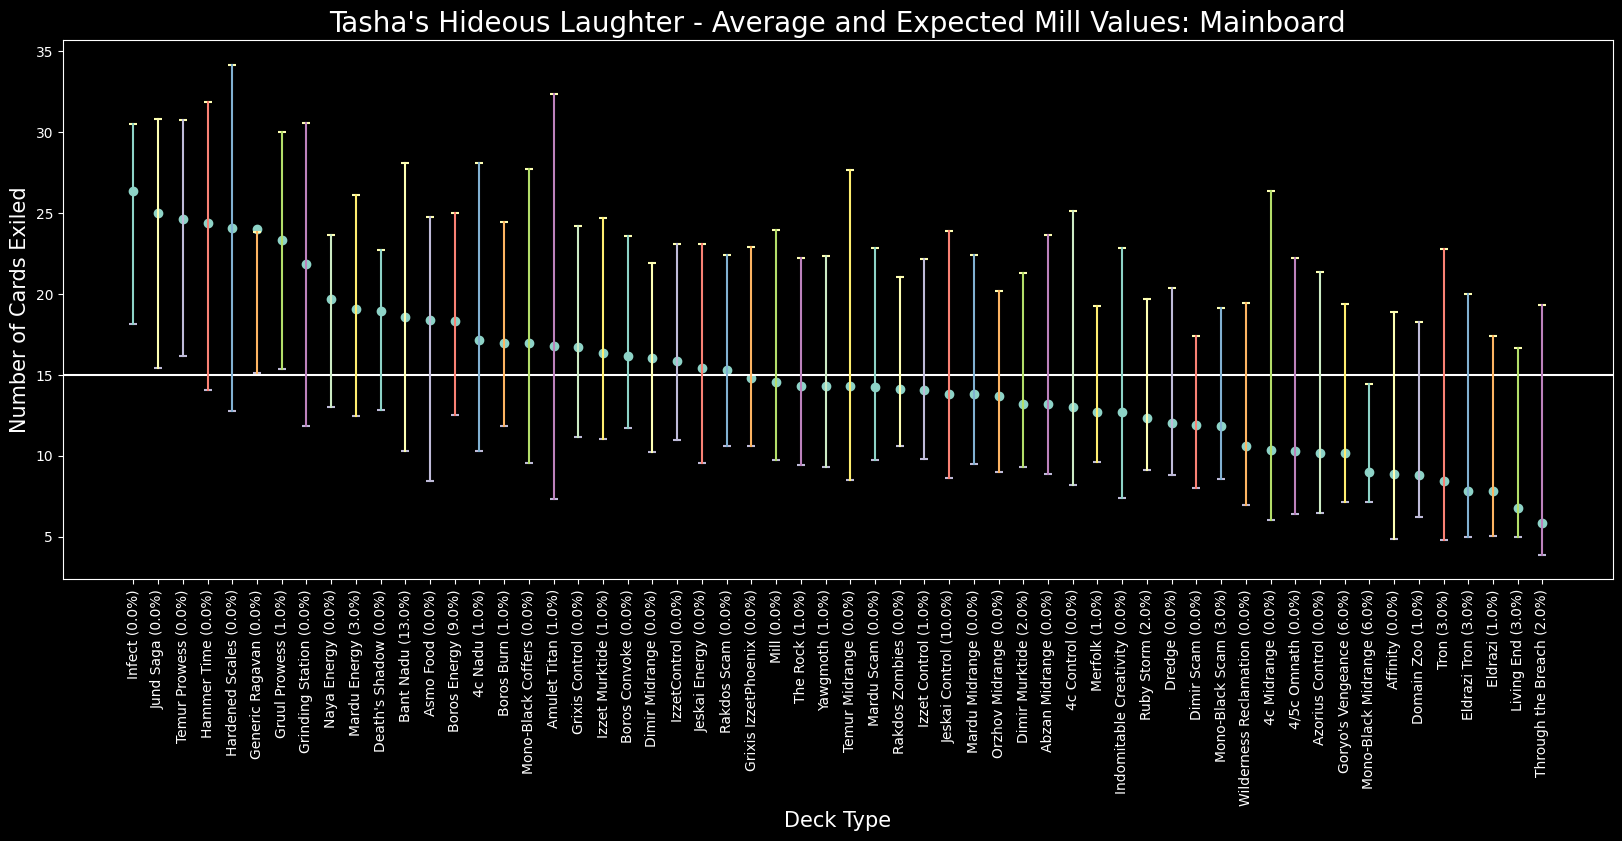

Average Cards Exiled (Mainboard): 15.002407624422672
Average Cards Exiled (Mainboard) - Weighted for Meta Share: 13.82207211519688


In [18]:
plt.style.use('dark_background')  # I find the dark background to be easier on the eyes
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)

ax.scatter(x=tasha_df['title_verbose'], y=tasha_df["mainboard_value"]) # Average Tasha's value
ax.scatter(x=tasha_df["title_verbose"], y=tasha_df["mainboard_maximum"], marker="_") # Maximum Tasha's Value
ax.scatter(x=tasha_df["title_verbose"], y=tasha_df["mainboard_minimum"], marker="_") # Minimum Tasha's Value

plt.title("Tasha's Hideous Laughter - Average and Expected Mill Values: Mainboard", fontsize=20)

plt.xlabel("Deck Type", fontsize=15)
plt.xticks(rotation=90)

plt.ylabel("Number of Cards Exiled", fontsize=15)
plt.yticks([0,5,10,15,20,25,30,35,40])

# Average Value 
plt.axhline(y=tasha_df["mainboard_value"].mean())
# Connect minimum and maximum hits
for deck in list(tasha_df["title_verbose"]):
    ax.plot([deck, deck], [tasha_df[tasha_df["title_verbose"]==deck]["mainboard_minimum"], tasha_df[tasha_df["title_verbose"]==deck]["mainboard_maximum"]])

#plt.text(x=-2, y=38.0, s=f"Average Cards Exiled (Mainboard): {tasha_df['mainboard_value'].mean()}")
#plt.text(x=-2, y=36.0, s=f"Average Cards Exiled (Mainboard) - Weighted for Meta Share: {sum(tasha_df['mainboard_value'] * tasha_df['meta_percentage'])}")

plt.show()

print(f"Average Cards Exiled (Mainboard): {tasha_df['mainboard_value'].mean()}")
print(f"Average Cards Exiled (Mainboard) - Weighted for Meta Share: {sum(tasha_df['mainboard_value'] * tasha_df['meta_percentage'])}")

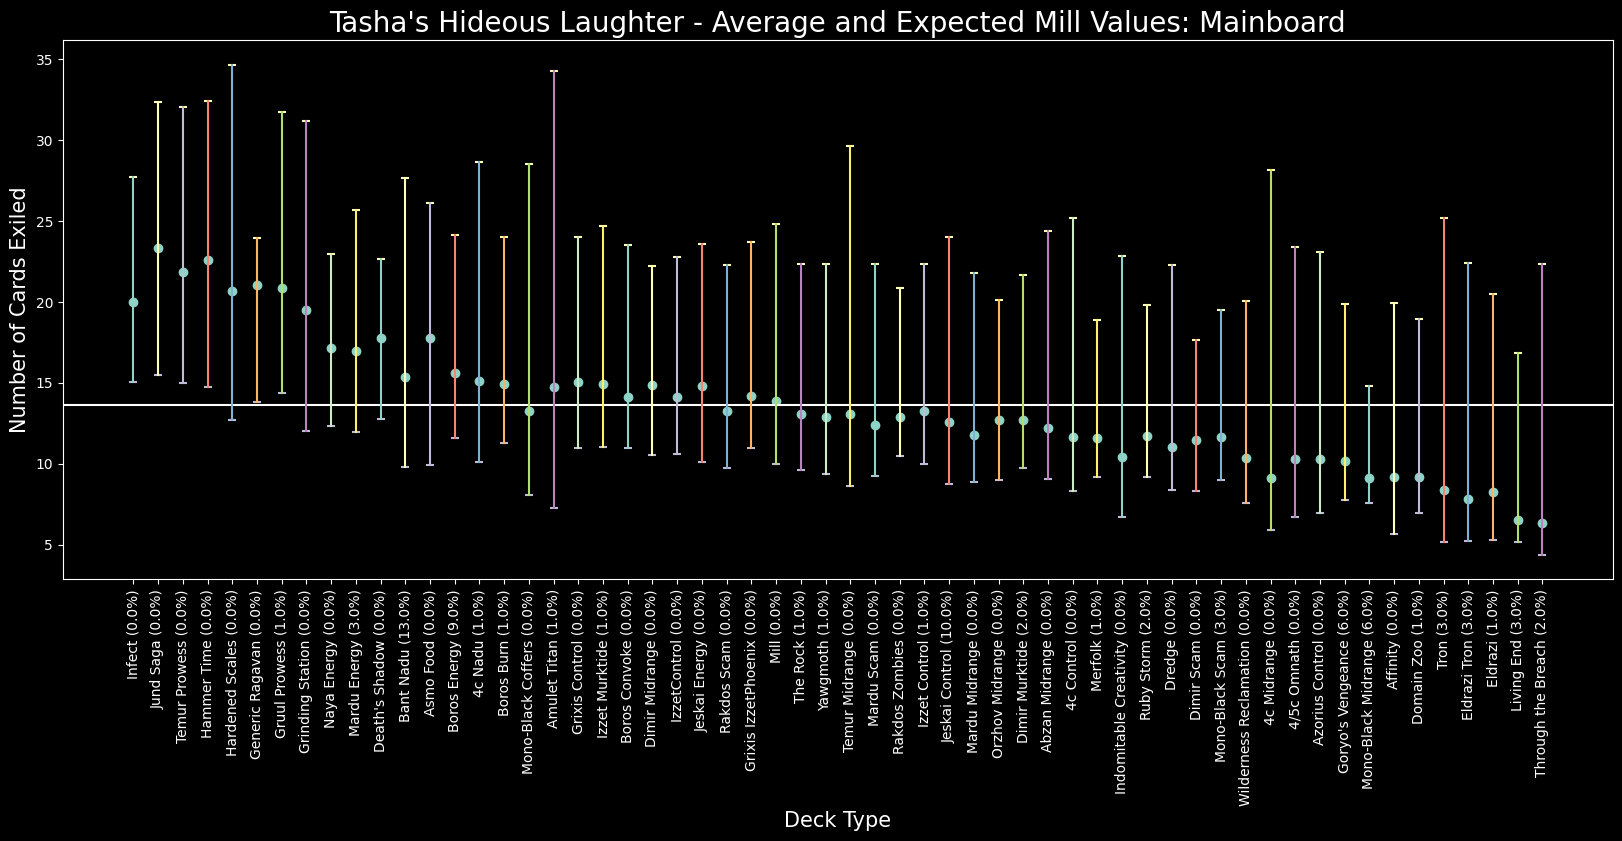

Average Cards Exiled (Overall): 13.641645180707547
Average Cards Exiled (Overall) - Weighted for Meta Share: 12.497622954701843


In [19]:
plt.style.use('dark_background')  # I find the dark background to be easier on the eyes
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)

ax.scatter(x=tasha_df["title_verbose"], y=tasha_df["overall_value"]) # Average Tasha's value
ax.scatter(x=tasha_df["title_verbose"], y=tasha_df["overall_maximum"], marker="_") # Maximum Tasha's Value
ax.scatter(x=tasha_df["title_verbose"], y=tasha_df["overall_minimum"], marker="_") # Minimum Tasha's Value

plt.title("Tasha's Hideous Laughter - Average and Expected Mill Values: Mainboard", fontsize=20)

plt.xlabel("Deck Type", fontsize=15)
plt.xticks(rotation=90)

plt.ylabel("Number of Cards Exiled", fontsize=15)
plt.yticks([0,5,10,15,20,25,30,35,40])

# Average Value 
plt.axhline(y=tasha_df["overall_value"].mean())
# Connect minimum and maximum hits
for deck in list(tasha_df["title_verbose"]):
    ax.plot([deck, deck], [tasha_df[tasha_df["title_verbose"]==deck]["overall_minimum"], tasha_df[tasha_df["title_verbose"]==deck]["overall_maximum"]])

#plt.text(x=-2, y=38.0, s=f"Average Cards Exiled (Overall): {tasha_df['overall_value'].mean()}")
#plt.text(x=-2, y=36.0, s=f"Average Cards Exiled (Overall) - Weighted for Meta Share: {sum(tasha_df['overall_value'] * tasha_df['meta_percentage'])}")

plt.show()

print(f"Average Cards Exiled (Overall): {tasha_df['overall_value'].mean()}")
print(f"Average Cards Exiled (Overall) - Weighted for Meta Share: {sum(tasha_df['overall_value'] * tasha_df['meta_percentage'])}")

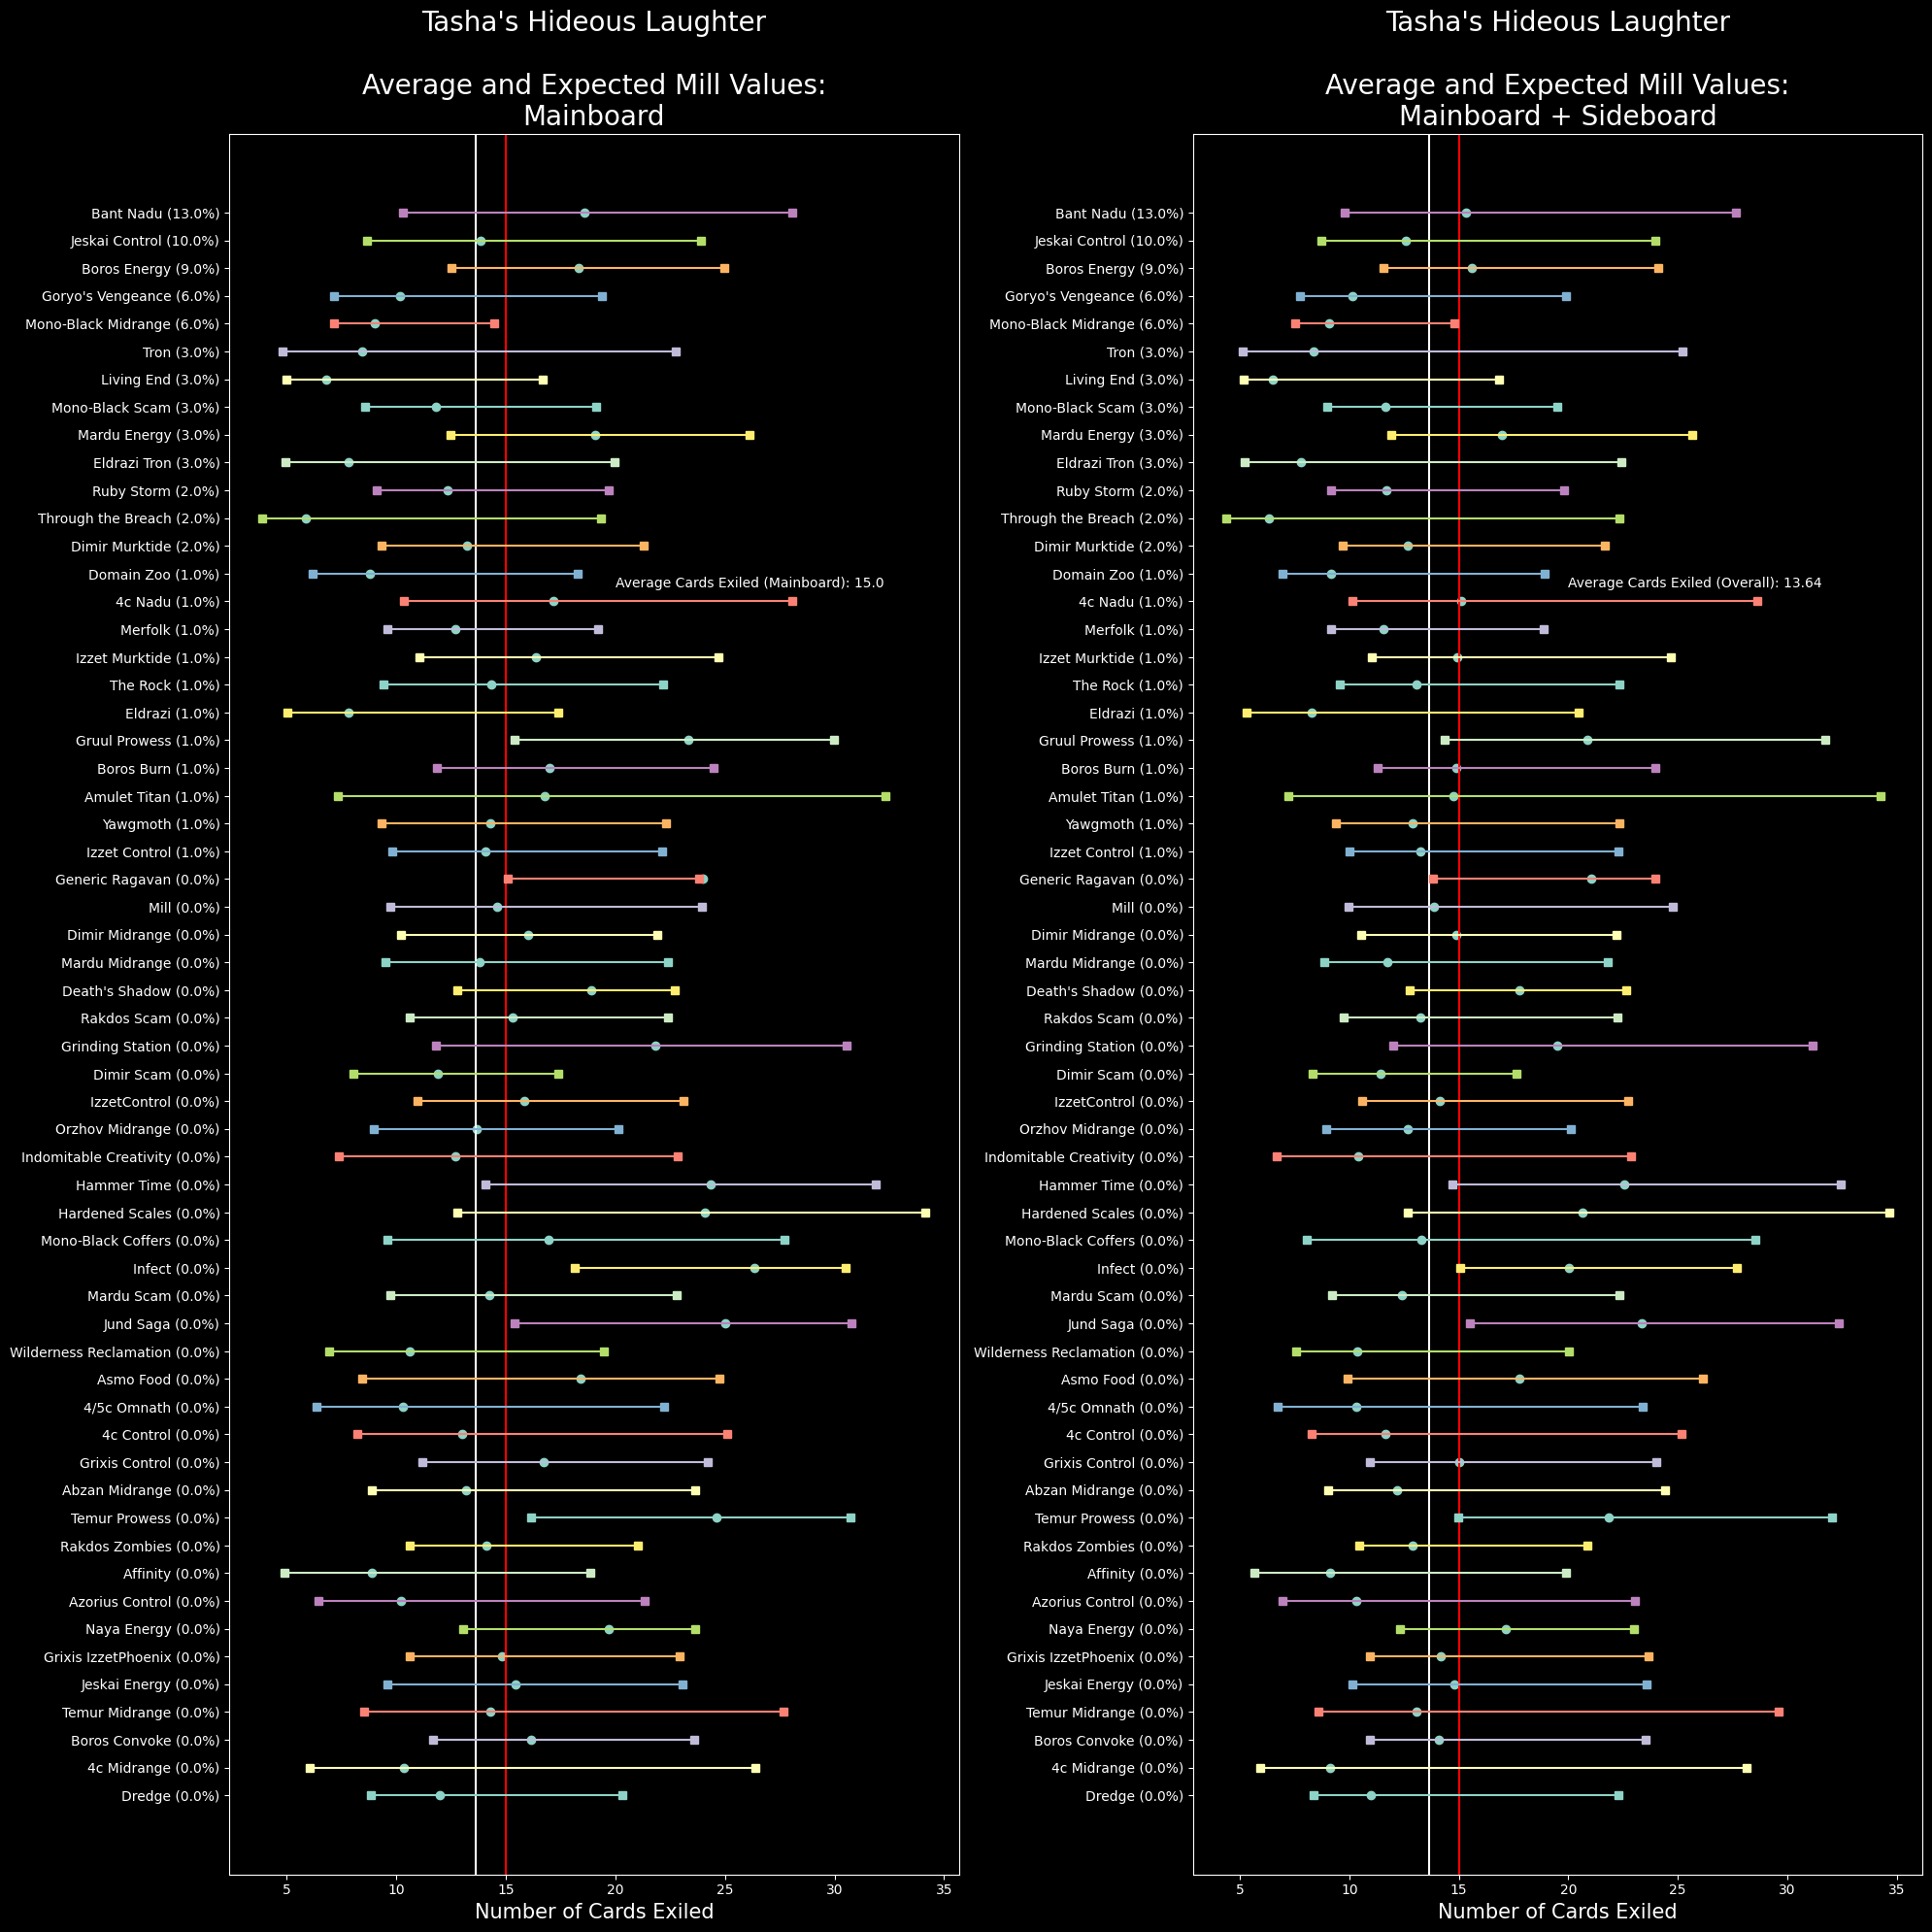

In [20]:
tasha_df.sort_values("meta_percentage", ascending=True, inplace=True)

plt.style.use('dark_background')  # I find the dark background to be easier on the eyes
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(121)

ax1.scatter(y=tasha_df["title_verbose"], x=tasha_df["mainboard_value"]) # Average Tasha's value
ax1.scatter(y=tasha_df["title_verbose"], x=tasha_df["mainboard_maximum"], marker="_") # Maximum Tasha's Value
ax1.scatter(y=tasha_df["title_verbose"], x=tasha_df["mainboard_minimum"], marker="_") # Minimum Tasha's Value

plt.title("Tasha's Hideous Laughter\n\nAverage and Expected Mill Values:\nMainboard", fontsize=20)

plt.yticks(tasha_df["title_verbose"])

plt.xlabel("Number of Cards Exiled", fontsize=15)
plt.xticks([0,5,10,15,20,25,30,35,40,45])

# Average Value 
plt.axvline(tasha_df["overall_value"].mean())
plt.axvline(x=tasha_df["mainboard_value"].mean(), color="r")
# Connect minimum and maximum hits
for deck in tasha_df["title_verbose"]:
    ax1.plot([tasha_df[tasha_df["title_verbose"]==deck]["mainboard_minimum"], tasha_df[tasha_df["title_verbose"]==deck]["mainboard_maximum"]], [deck, deck], marker="s")

plt.text(x=20, y=43.5, s=f"Average Cards Exiled (Mainboard): {round(tasha_df['mainboard_value'].mean(), 2)}")

"""
    Below is the plot for overall vertical plot
"""

ax2 = fig.add_subplot(122)

ax2.scatter(y=tasha_df["title_verbose"], x=tasha_df["overall_value"]) # Average Tasha's value
ax2.scatter(y=tasha_df["title_verbose"], x=tasha_df["overall_maximum"], marker="_") # Maximum Tasha's Value
ax2.scatter(y=tasha_df["title_verbose"], x=tasha_df["overall_minimum"], marker="_") # Minimum Tasha's Value

plt.title("Tasha's Hideous Laughter\n\nAverage and Expected Mill Values:\nMainboard + Sideboard", fontsize=20)

plt.yticks(tasha_df["title_verbose"])

plt.xlabel("Number of Cards Exiled", fontsize=15)
plt.xticks([0,5,10,15,20,25,30,35,40,45])

# Average Value 
plt.axvline(tasha_df["overall_value"].mean())
plt.axvline(x=tasha_df["mainboard_value"].mean(), color="r")
# Connect minimum and maximum hits
for deck in tasha_df["title_verbose"]:
    ax2.plot([tasha_df[tasha_df["title_verbose"]==deck]["overall_minimum"], tasha_df[tasha_df["title_verbose"]==deck]["overall_maximum"]], [deck, deck], marker="s")

plt.text(x=20, y=43.5, s=f"Average Cards Exiled (Overall): {round(tasha_df['overall_value'].mean(), 2)}")

fig.tight_layout()
plt.show()

## Conclusions

On average, Tasha's performs similarly to Fractured Sanity in the first game of the match, with an expected level of variance and matchup dependence. From the first graph, one can see the matchups which are best. At the time of this writeup, the top decks in the meta game are "Cascade Crash", "Creature Toolbox", "Rakdos Aggro", "UR Aggro", and "Amulet Titan". Based only on these decks, Tasha's seems like a great card, with it only performing poorly against "Cascade Crash". 

However, after sideboarding occurs, Tasha's becomes less valuable in terms of cards milled, becoming much worse against each of the mentioned decks. While "UR Aggro" remains above average in value, it goes from good to mediocre against "Amulet Titan" and "Rakdos Aggro" and mediocre to bad against "Creature Toolbox". Despite this, it is important to remember that shuffle effects tend to be more prevalent in the "Overall" matches, and the value of Tasha's Hideous Laughter's exile benefit becomes more relevant.

There is also one more thing to keep in mind when playing this card, and that is the cards that the mill plaer knows are NOT in the opponent's library. A mill player can use information from cards in the graveyad, in exile, and on the field to determine what cards might remain in the deck. Cards such as Surgical Extraction can also be used to thin out high mana value cards while getting information about the other player's hand and what cards are in the deck while lowering the deck's average cmc. 

![Surgical Extraction](http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=571427&type=card)

Calculation for this effect is difficult to quantify because it relies heavily on the deck. But it goes without saying that targeting the higher mana value cards in a deck can greatly increase the number of cards milled by Tasha's.

# Sanity Grinding

![Sanity Grinding](http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=157204&type=card)

This card is not commonly played, and is largely viewed as a bad card. At the same price as Tasha's Hideous Laughter and Fractured Sanity but with no additional benefit beyond "mill the opponent", this card needs to outperform both of the aforementioned cards. Luckily, this card does not rely on the opponent's deck to get value. Instead, this card takes into account the mill player's library and the number of blue mana costs on the card. This card also benefits itself greatly, having three blue mana values on it.

I fully expect this card to underperformed compared to the other cards, but it is a card that is still worth exploring.

## Method

First, we need to take a the average mill deck, which was found previously, and add between 1 and 4 of this card. This is similar to to the process performed for Tasha's Hideous Laughter, but will involve multiplying the average value by the blue mana values on the card, and involve calculating for four different instances.

Second, we can now find the average number of blue mana symbols for each card. In doing this, we can remove three of the 0-value cards, because we need at least three lands on the field in order to cast this spell.

Finally, we can plot the findings for each instance.

### Retrieve the Average Card Prevalence

In [26]:
MainboardMillMean = Mainboard[Mainboard.index.str.contains("Mill")]
MainboardMillMean = MainboardMillMean[MainboardMillMean.astype(bool)].fillna(0)
mill_deck_size = MainboardMillMean.sum(axis=1)

### Multiply in the Blue Cost

In [28]:
cards_cost_blue_columns = [mana_value for mana_value in CardsCost.columns if "U" in mana_value]
cards_cost_blue_columns.append('name')
CardsCostBlue = CardsCost[cards_cost_blue_columns].set_index('name')

In [45]:
MainboardMillMean_U = MainboardMillMean.copy()
MainboardMillMean_Total = MainboardMillMean.copy()

In [46]:
for card in set(MainboardMillMean.index):
    if card in list(blue_mana_values.keys()):
        blue_pips = blue_mana_values[card]
    else:
        blue_pips = CardsCostBlue.loc[card].iloc[0].sum()
        total_pips = CardsCost[CardsCost['name']==card].drop(["N", "X", "name"], axis=1).iloc[0].sum()

    blue_mana_values[card] = blue_pips
    MainboardMillMean_U.loc[card] = MainboardMillMean_U.loc[card] * blue_pips
    MainboardMillMean_Total.loc[card] = MainboardMillMean_Total.loc[card] * total_pips

total_blue_pips = MainboardMillMean_U.sum()
total_pips = MainboardMillMean_Total.sum()

print(total_blue_pips)
print(total_pips)

44.85
59.89999999999999


### Find Average Blue Mana Value for Each Added Copy of Sanity Grinding

For each copy assumed to be in the deck, we must subtract the cast copy. For example, assuming that there are 4 copies of Sanity Grinding in the deck, only 3 can be in the player's library because the fourth copy is being cast. We must also take into account that three land cards must have been played, meaning that we will subtract 3 from the deck size in each instance, and add the additional copies of Sanity Grinding to the deck size.

In [47]:
average_sg_value = []
average_sg_value_total = []

for i in range(0,4):
    average_b_value = (total_blue_pips + (i * 3)) / (mill_deck_size - 3 + i)
    average_sg_value.append(average_b_value * 10)

    average_total_value = (total_pips + (i * 3)) / (mill_deck_size - 3 + i)
    average_sg_value_total.append(average_total_value * 10)

### Plot Findings

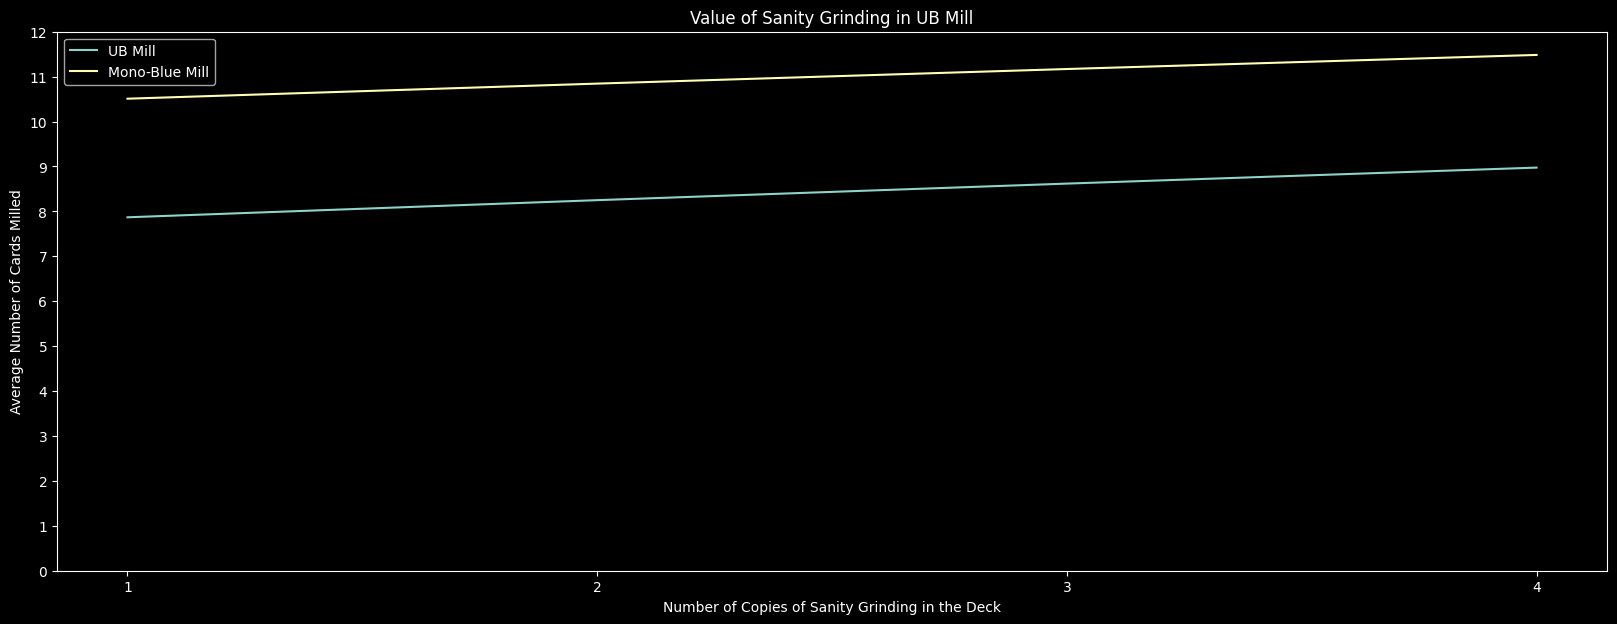

In [48]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)

ax.plot([i for i in range(1,5)], average_sg_value, label="UB Mill")
ax.plot([i for i in range(1,5)], average_sg_value_total, label="Mono-Blue Mill")

plt.title("Value of Sanity Grinding in UB Mill")

plt.xlabel("Number of Copies of Sanity Grinding in the Deck")
plt.ylabel("Average Number of Cards Milled")

plt.xticks([i for i in range(1,5)])
plt.yticks([i for i in range(0, 13)])

plt.legend()

plt.show()

## Conclusion

This card is simply not good for the mana cost. Tasha's Hideous Laughter mills more cards with the added benefit of exiling the removed cards while Fractured Sanity is generally going to mill more cards in most situations. Even if the deck were to be changed into a hypothetical one color (Blue) deck, this card would still underperform both of the other mentioned cards, while losing the beneficial cards that can be found in the second color.

# Mind Funeral

![Mind Funeral](http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=370509&type=card)

This card is not commonly played, and is largely viewed as a bad card. At the same price as Tasha's Hideous Laughter and Fractured Sanity but with no additional benefit beyond "mill the opponent", this card needs to outperform both of the aforementioned cards. This card mills until 4 land cards are found, which might be good against certain decks, but not every deck. Decks like "Amulet Titan" which can have over half of their deck be lands would be a poor use of this spell, but fewer lands in adeck can result in a better performance.

This is an easy calculation, and so it is worth looking at. I expect very little from this card, despite how fun it might be.

## Method

First, lands need to be separated from the non-lands. "Mind Funeral" mills based on the number of lands milled, requiring us to determine the likelihood of a land being milled on any particualr draw.

Second, once the likelhood of a draw being a land or not is determined, then we can determine this cards effectiveness.

Finally, a plot will be made to show the effectiveness of this card against the meta decks.

### Create a count of lands and nonlands for each deck

In [49]:
MindFuneralCount = pd.DataFrame(columns=['name', 'lands', 'non_lands'])
land_dict = {"Molten Collapse": 0, "Agatha's Soul Cauldron": 0, "Echoing Deeps": 1, 'Lůrien Revealed': 0, 'Confounding Riddle': 0, 'Troll of Khazad-dűm': 0, 
             'Sleep-Cursed Faerie': 0, 'Brackish Blunder': 0, 'Questing Druid': 0, 'Deeproot Pilgrimage': 0, 'Stalactite Stalker': 0, 'Souls of the Lost': 0, 
             'Amalia Benavides Aguirre': 0, 'Cenote Scout': 0, 'Inti, Seneschal of the Sun': 0, 'Bitter Triumph': 0, 'Spelunking': 0, 'Experimental Confectioner': 0, 
             'Get Lost': 0, 'Volatile Fault': 1, 'Sunken Citadel': 1, 'Not Dead After All': 0, "Tishana's Tidebinder": 0, 'L¾rien Revealed': 0,
             'Lush Portico': 1, "Worldsoul's Rage": 0, 'Kellan, Inquisitive Prodigy': 0, "Dreadmaw's Ire": 0, 'Snarling Gorehound': 0, 'Hidden Volcano': 1,
             'Thundering Falls': 1, 'Doorkeeper Thrull': 0, "The Witch's Vanity": 0, 'Candy Trail': 0, 'Reenact the Crime': 0, 'Leyline of the Guildpact': 0,
             'Beseech the Mirror': 0, 'Break Out': 0, 'Syr Ginger, the Meal Ender': 0, 'Pick Your Poison': 0, 'Case of the Ransacked Lab': 0, 'Deduce': 0,
             'Warden of the Inner Sky': 0, "Night of the Sweets' Revenge": 0, 'Shadowy Backstreet': 1, 'Cryptic Coat': 0, 'Hedge Maze': 1, 'Elegant Parlor': 1,
             'Insidious Roots': 0, 'Kraul Whipcracker': 0, 'Long Goodbye': 0, 'Meticulous Archive': 1, 'Tough Cookie': 0, "Archdruid's Charm": 0,
             'Preacher of the Schism': 0, 'Case of the Filched Falcon': 0, 'Horned Loch-Whale': 0, 'Undercity Sewers': 1, 'Commercial District': 1,
             'Heartflame Duelist': 0, 'No More Lies': 0, 'Decadent Dragon': 0, 'Deadly Cover-Up': 0, 'Novice Inspector': 0, 'Underground Mortuary': 1,
             'Raucous Theater': 1, 'Virtue of Persistence': 0, 'Unauthorized Exit': 0, 'Werefox Bodyguard': 0, 'Trumpeting Carnosaur': 0, 'Kutzil, Malamet Exemplar': 0,
             'Akal Pakal, First Among Equals': 0, 'Geological Appraiser': 0, 'Steamcore Scholar': 0, 'Royal Treatment': 0, 'Case of the Crimson Pulse': 0, 'Monstrous Rage': 0,
             'Stormkeld Vanguard': 0, 'Vein Ripper': 0, 'Troll of Khazad-d¹m': 0, "Krenko's Buzzcrusher": 0, 'Analyze the Pollen': 0, 'Wail of the Forgotten': 0,
             'Outrageous Robbery': 0, 'Restless Ridgeline': 1, 'Sentinel of the Nameless City': 0, 'Delney, Streetwise Lookout': 0}     
             
missing_cards = []
alt_card = ""

for deck in deck_types:
    lands = 0
    non_lands = 0

    temp_df = MainboardMean.loc[deck]
    temp_df = temp_df[temp_df.astype(bool)].fillna(0)
    for card in list(temp_df.index):
        # Check local dictionary first to increase speed of process
        if card in list(land_dict.keys()):
            if land_dict[card] == 0:
                non_lands += temp_df.loc[card]
            elif land_dict[card] == 1:
                lands += temp_df.loc[card]
            else:
                print(card)
                raise ValueError(f"Wrong Value in land_dict: {land_dict[card]}")

            continue

        # Handle Alt-Cards
        if " / " in card:
            alt_card = card
            card = card.split(" / ")[0]

        # Check if present in database
        if len(CardsTypes[CardsTypes['name']==card].index) == 0:
            missing_cards.append(card)
            continue

        # Find in Card Database and save locally
        if CardsTypes[CardsTypes['name']==card]['Land'].iloc[0] > 0:
            if card in alt_card:
                lands += temp_df.loc[alt_card]
                land_dict[alt_card] = 1
            else:
                lands += temp_df.loc[card]
                land_dict[card] = 1
        else:
            if card in alt_card:
                non_lands += temp_df.loc[alt_card]
                land_dict[alt_card] = 0
            else:
                non_lands += temp_df.loc[card]
                land_dict[card] = 0

    MindFuneralCount.loc[len(MindFuneralCount.index)] = [deck, lands, non_lands]

print(set(missing_cards))

set()


In [50]:
MindFuneralCount['deck_size'] = MindFuneralCount[['lands', 'non_lands']].sum(axis=1)

### Calculate Percentages for each deck

In [51]:
MindFuneralCount.set_index('name', inplace=True)

In [52]:
MindFuneralCount[['land_percentage', 'non_land_percentage']] = MindFuneralCount[['lands', 'non_lands']].div(MindFuneralCount[['lands', 'non_lands']].sum(axis=1), axis=0)

In [53]:
"""
We are taking the probability of each permutation in which the nth land (4 for Mind Funeral) can be. By taking the overall permutations of the deck, and then finding the probability of each spot which
the nth land can be, we can add the probabilities to find the average cards pulled.
"""
def probability_of_n_reveals(land_count, non_land_count, n=4):
    if land_count == 0:
        return land_count + non_land_count

    deck_count = land_count + non_land_count
    unique_permutations = math.factorial(deck_count) / (math.factorial(land_count) * math.factorial(non_land_count))  # Gives unique number of permutations of deck
    total_permutations = 0
    max_location = deck_count - (land_count - n)  # Gives furthest location into deck that one might find a land card that would allow n to equal set value, while n = minimum location
    out = 0

    for i in range(0, (max_location - n + 1)):
        # n+1 is indicative of the position of the nth land
        # n is always going to be the land_count, beecause we are looking at unique permutations before it
        # i represents non_land_count, because it fills in the gaps for missing lands in the position tracked
        permutations_before = math.factorial(n + i - 1) / ((math.factorial(n - 1) * math.factorial(i))) # the number of permutations where the desired card is in location i
        permutations_after = math.factorial(deck_count - (n + i)) / ((math.factorial(land_count - n)) * math.factorial(non_land_count - i)) # the number of permutations following the desired card location
        permutations = permutations_before * permutations_after # The makeup of cards before and after will not change when calculating for a single spot, so we can multiply to find total permutations
        
        out += (n + i) * permutations / unique_permutations # Location of the nth card times the probability that it is there

    return out

In [54]:
MindFuneralCount["mind_funeral_average"] = MindFuneralCount.apply(lambda x: probability_of_n_reveals(round(x.lands), round(x.non_lands), 4), axis=1)

### Plot Findings

In [55]:
MindFuneralCount.sort_values("mind_funeral_average", ascending=True, inplace=True)

In [56]:
MindFuneralClear = MindFuneralCount.drop('Landless', axis=0, errors='ignore')

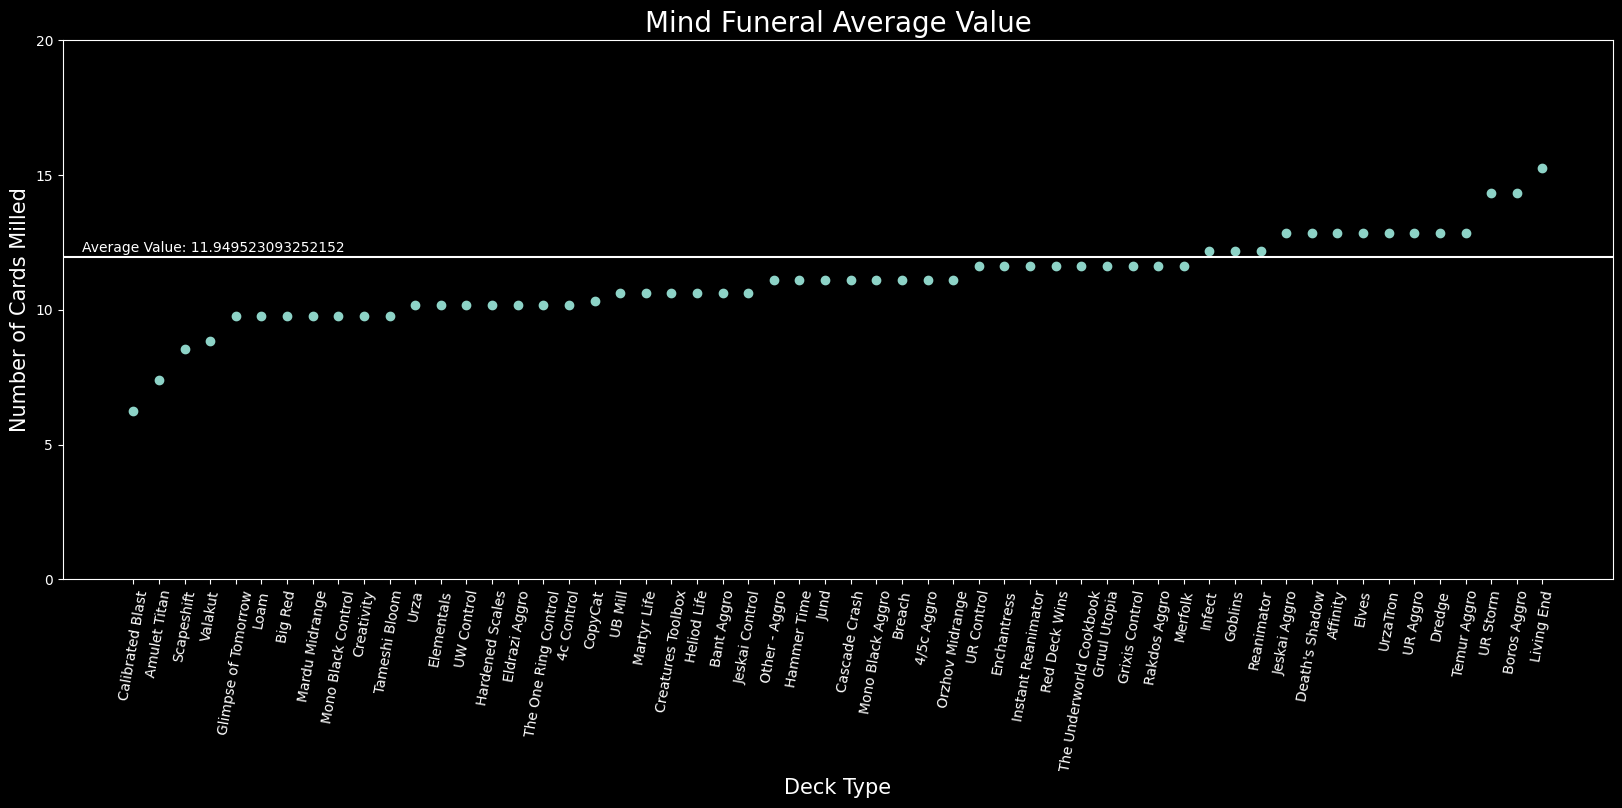

In [57]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)

plt.title("Mind Funeral Average Value", fontsize=20)
plt.xlabel("Deck Type", fontsize=15)
plt.ylabel("Number of Cards Milled", fontsize=15)

ax.scatter(x = MindFuneralClear.index, y = MindFuneralClear["mind_funeral_average"])

plt.xticks(rotation=80)
plt.yticks([i for i in range(0, 25, 5)])

average = MindFuneralCount["mind_funeral_average"].mean()
#average_without_landless = MindFuneralCount.drop('Landless', axis=0)["mind_funeral_average"].mean()

plt.axhline(average)
plt.text(x=-2, y=average+0.2, s=f"Average Value: {average}")

#plt.axhline(average_without_landless)
#plt.text(x=-2, y=average_without_landless+0.2 , s=f"Average Value without Landless: {average_without_landless}")

plt.show()


## Conclusions

The deck type "Landless", which holds a very small percentage of the metagame, was removed for the sake of clarity. The deck has no lands, and so Mind Funeral would automatically win the game. If you were to face this deck, this card is the best card you could possibly play, but I must admit that this card is better than I had originally thought it would be.

The biggest thing to note is how much more tightly packed this chart is compared to Tasha' Hideous Laughter, denoting a more even experience. The average value is also comparable to Tasha's Hideous Laughter after sideboarding, an instance when Mind Funeral would actually get better, because there is a smaller lands to non-land ratio, reducing the likelihood of a land being revealed.

I believe it is also worth noting that decks tend to run multiple ways to search for lands as a way to make their mana base more accessible for mulitple colors in the deck. As a result, this card would get better in the same instances that would make Tasha's Hideous Laughter worse. However, Tasha's is still slightly better in terms of cards milled, milling about two to three cards more on average and exiling the cards rather than putting them in the graveyard.

However, this does not mean that Tasha's Hideous Laughter is better in all instances. There are some decks, such as "Living End", where Mind Funeral is better and shoudl be considered when looking at a local meta. But Tasha's is generally going to be better overall and in more matchups. Tasha's held up against Fractured Sanity while Mind Funeral does not. In fact, Mind Funeral fits the same exact spot as Fractured Sanity, but it appears to be worse than that card.

Unfortunately, Mind Funeral appears to not be good enough for Modern Mill and provide enough utility to cover up its shortcomings.

# Hedron Crab / Ruin Crab Value over Time

<img src="http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=180348&type=card" alt="drawing" width="225"/>
<img src="http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=491705&type=card" alt="drawing" width="225"/>

These two creatures are highly prevalent and effective in mill, sometimes lending the name "8-Crab" to mill decks. Each time a land is played (only one land can be played per turn, unless another card would allow you to play more) by the crab's owner, the opponent mills three cards. Assuming no removal, each crab can mill three cards per turn. This might not seem like a lot when there are 60 cards in a deck, but this adds up over time and with multiple instances of crabs.

This ability is also benefitted by the use of "Fetch Lands" (lands which allow their owner search for other lands and put them on the battlefield) and the card "Field of Ruin" (when used, will allow each player to search for a absic land while destroying a non-basic land which that opponent controls). These cards can be used to trigger each crab to twice on that turn instead.

<img src="http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=405104&type=card" alt="drawing" width="225"/>
<img src="http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=535060&type=card" alt="drawing" width="225"/>

Assuming a land is played each turn, and the use of between 8 and 11 of these types of cards, what is the return value for these crabs?

## Method

First, we will formulate a method that will calculate average land draws for each turn, with a chance of two lands being triggered as the result of one of the above mentioned land cards. Between 8 and 11 of these cards will be tested to observe the effect of the crabs for each turn of the game. These cards reduce the likelihood of lands being played in the future. The player starts with 7 cards in hand, and so we can calculate land likelihood as well based on a subset of cards that would be in hand. By taking a subset of cards to represent those drawn throughout the game, and calculating the chance that a number of land cards would be in hand, we can track the value of a crab for each turn along with value over time.

Second, this is where the method previously created is applied to discover the value achievable from a crab for each turn, keeping in mind that a single land (we will assume it is not a fetch-land/Field of Ruin) must be played before the crab can be played. Because of this, a single non-land card will be removed (for the crab) and a single land will be removed (for the land that had to be played in order to cast the crab).

Finally, we will plot the prevalence of lands and the value of each crab in the deck.

### Data Preparation

In [58]:
MainboardMillLandBool = pd.Series([land_dict[card] for card in list(MainboardMillMean.index)], index=list(MainboardMillMean.index), name="land_bool")

In [59]:
MainboardCrab = pd.concat([MainboardMillMean, MainboardMillLandBool], axis=1, keys=["avg_cards_played", "land_bool"])

In [60]:
fetch_ruin_lands = ["Arid Mesa", "Bloodstained Mire", "Flooded Strand", "Marsh Flats", "Misty Rainforest", "Polluted Delta", "Scalding Tarn", "Verdant Catacombs", "Windswept Heath", "Wooded Foothills", "Field of Ruin", "Ghost Quarter"]
MainboardCrab["fetch_ruin"] = MainboardCrab.index.isin(fetch_ruin_lands)
MainboardCrab["fetch_ruin"] = MainboardCrab["fetch_ruin"].apply(lambda x: 1 if x==True else 0)

In [61]:
# Prints out the average "Fetch and Ruin" lands in the average mill deck
average_fetch_ruin = MainboardCrab["fetch_ruin"] * MainboardCrab["avg_cards_played"]
average_land_cards = MainboardCrab["land_bool"] * MainboardCrab["avg_cards_played"]
print(f"Average Number of Fetch Lands + Field of Ruins in Mill: {average_fetch_ruin.sum()}")
print(f"Average Number of Land Cards in Mill: {average_land_cards.sum()}")

Average Number of Fetch Lands + Field of Ruins in Mill: 10.8
Average Number of Land Cards in Mill: 22.05


### Formulate method for land prevalence

While I would like to average the cards in terms of lands over all cards and create a linear graph to represent the return investment in playing a single Crab, I understand that this throws away too much information. Fetch lands and Field of Ruin reduces the number of cards in the deck and reduces land cards remaining without actually changing the turn, effectively turning one turn into the equivalent of two for Crab value. However, I can't just add additional cards to the 60 card deck to act as if these lands were two, because the percentages are thrown off. This is fundamentally different from a single card representing two cards.

The only way to calculate this is to view the deck as three different cards: non-land cards, land cards, and fetch/ruin lands. Non-land cards will be treated as blank cards worth zero value, land cards will be treated as a 3 value card, and fetch/ruin lands will be treated as a 6 value card that reduces the number of lands after it. I will run this, assuming 10-15 hands played. Games rarely go beyond 10 turns. This will also reduce the computational load that will exponentially increase, the more hands are looked at.

I will assume that turn one includes one land, that provides zero value to the crab. As a result, I will remove the first normal land encountered. I will also assume that there is at least one land card and one non-land card in the starting hand, so that the Crab can be assumed playable.

I will have to recursively calculate probabilities, keeping track of the percentages for each probability drawn and the value gained so that appropriate value over time can be predicted at the end. Turn one will be treated as turn zero. One land card and one non-land card will be removed and 5 cards will be held in hand to simulate a reserve of cards. Non-land cards will be removed, and the number of cards remaining will represent the number of lands which can be played if one was not drawn.

I will assume 22 lands total in the deck. Testing will be done for a range of fetch/ruin lands between 8 and 11, which leaves 11 to 14 land cards for the sake of this experiment. This also means that there are 38 non-land cards.

At the start of this experiment we will assume:
* 10-13 Land Cards
* 8-11 Fetch/Ruin Land Cards
* 37 Non-Land Cards

In [62]:
def crabValueCheckonDraw(land_count, fetch_ruin_count, non_land_count, turn_number, hand_pool):
    land_totals_checked = []

    # for draw, calculate value assuming a land was played each turn
    total_land_count = land_count + fetch_ruin_count
    trigger_value = 0
    permutations_total = 0
    for land_total in range(turn_number, hand_pool + 1):
        for l in range(0, land_total + 1):
            f = land_total - l  # number of fetches to make up land total

            if f > fetch_ruin_count:
                    continue

            # change deck size in calculation to find permutations in which fetch/ruin lands were played previously
            for f_played in range(0, turn_number):
                if l + f_played > land_count:
                    continue
                elif f > fetch_ruin_count:
                    continue
                elif l + f_played == land_count:
                    average_crab_trigger = 3
                else:
                    average_crab_trigger = 3 * (2*(f) + (l)) / land_total

                # Each fetch/ruin involves reducing land count and deck size
                deck_size = total_land_count + non_land_count - f_played
                library_state_size = deck_size - hand_pool - f_played
                
                # permutations of the hand state
                non_land = hand_pool - f - l
                hand_state_permutations = math.factorial(hand_pool) / (math.factorial(l) * math.factorial(f) * math.factorial(non_land))
                # permutations of the library state
                library_l = land_count - l - f_played
                library_f = fetch_ruin_count - f
                library_non_land = non_land_count - non_land
                library_state_permutations = math.factorial(library_state_size) / (math.factorial(library_l) * math.factorial(library_f) * math.factorial(library_non_land))
                # overall permutations
                permutations = math.factorial(deck_size) / (math.factorial(land_count - f_played) * math.factorial(fetch_ruin_count) * math.factorial(non_land_count))

                trigger_value += average_crab_trigger * hand_state_permutations * library_state_permutations

                land_number = total_land_count - f_played
                if land_number in land_totals_checked:
                    continue
                else:
                    land_totals_checked.append(land_number)
                    permutations_total += permutations  # The minimum cards in possible cards in deck should be covered here, and thus all possible permutations.

    # calculate for instances where land drops were missed
    # This should cover instances in which a land or ruin/fetch land was drawn and can be played, or none is drawn and a land drop is missed
    for land_total in range(0, turn_number):
        # Assuming the last card in the hand pool is a land or fetch/ruin land, find permutations that fit criteria
        for f_played in range(0, land_total):
            if f_played >= fetch_ruin_count:
                continue
            if land_total + f_played > land_count:
                continue
            
            l_played = land_total - f_played

            deck_size = total_land_count + non_land_count - f_played

            library_left = deck_size - hand_pool - f_played
            land_left = land_count - l_played - f_played
            fetch_left = fetch_ruin_count - f_played
            non_land_left = library_left - land_left - fetch_left

            # Represents cards already in hand, and the drawn land or fetch/ruin card
            hand_state_prior_draw = math.factorial(hand_pool - 1) / (math.factorial(l_played) * math.factorial(f_played) * math.factorial(hand_pool - 1 - l_played - f_played))

            # Assume land was drawn
            lands_in_deck = math.factorial(library_left - 1) / (math.factorial(land_left - 1) * math.factorial(fetch_left) * math.factorial(non_land_left))
            land_drawn_trigger = 3 * (hand_state_prior_draw * lands_in_deck)
            trigger_value += land_drawn_trigger

            # Assume fetch/ruin was drawn
            fetch_in_deck = math.factorial(library_left - 1) / (math.factorial(land_left) * math.factorial(fetch_left - 1) * math.factorial(non_land_left))
            if land_left == 0:
                fetch_drawn_trigger = 3 * (hand_state_prior_draw * fetch_in_deck)
            else:
                fetch_drawn_trigger = 6 * (hand_state_prior_draw * fetch_in_deck)
            trigger_value += fetch_drawn_trigger

    return trigger_value / permutations_total

In [63]:
turn = 1
crabValueCheckonDraw(land_count=11, fetch_ruin_count=11, non_land_count=(60-22), turn_number=turn, hand_pool=(7+turn))

4.413990494359472

for given "hand size", calculate the likelihood of each number of draws


calculate probability of a land or fetch/ruin land being played
    Subtract pervious hands where there were either no lands to play or just enough lands to play, but keep permutations where the last card is a land/fetch

track each turn, the number of times a fetch/ruin land is played, so that we can track from a "land card" played on the next permutations
    Ex: turn 2
        {(land played) + (2 * fetch/ruin played) + [assuming turn 1 fetch = (land played) + (2 * fetch/ruin played)]} / {number of perumations + number of permutations with one less card in deck}

### Apply method to deck values

In [64]:
land_cards = [10, 11, 12, 13]
fetch_ruin = [11, 10,  9,  8]
non_land   = [37, 37, 37, 37]

crab_line_on_play  = [[], [], [], []]
crab_line_on_draw = [[], [], [], []]

In [65]:
crab_value_by_turn = []
for i in range(len(land_cards)):
    for turn in range(1,10):
        crab_value = crabValueCheckonDraw(land_count=land_cards[i], fetch_ruin_count=fetch_ruin[i], non_land_count=non_land[i], turn_number=turn, hand_pool=(5+turn))
        crab_line_on_play[i].append(crab_value)
        crab_value = crabValueCheckonDraw(land_count=land_cards[i], fetch_ruin_count=fetch_ruin[i], non_land_count=non_land[i], turn_number=turn, hand_pool=(6+turn))
        crab_line_on_draw[i].append(crab_value)

### Plot Findings

In [66]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

colors_list = list(mcolors.TABLEAU_COLORS.values())

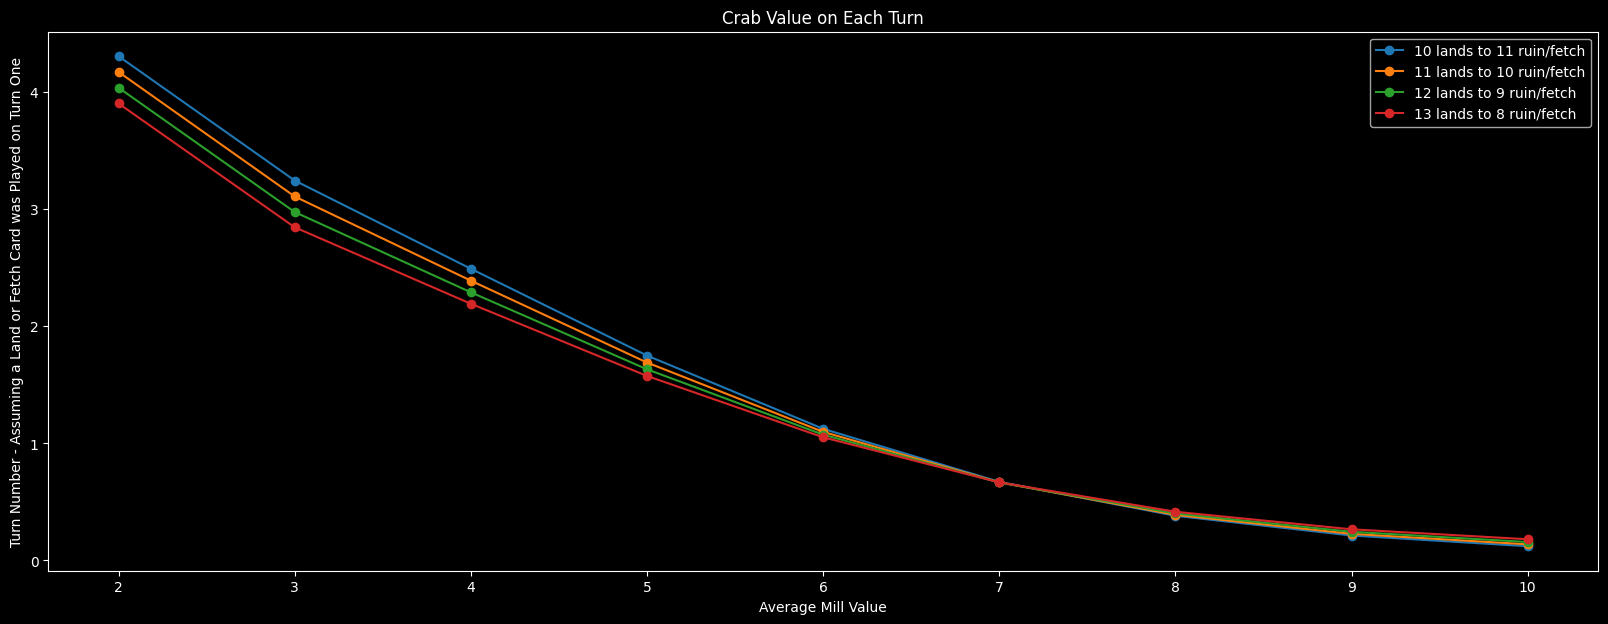

In [67]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)

for i in range(len(crab_line_on_play)):
    ax.plot([i+2 for i in range(len(crab_line_on_play[i]))], crab_line_on_play[i], marker="o", color=colors_list[i], label=f"{land_cards[i]} lands to {fetch_ruin[i]} ruin/fetch")

plt.title("Crab Value on Each Turn")

plt.xlabel("Average Mill Value")
plt.ylabel("Turn Number - Assuming a Land or Fetch Card was Played on Turn One")

plt.xticks([i+2 for i in range(len(crab_line_on_play[i]))])

plt.legend()

plt.show()

In [68]:
crab_summed_on_play = []

for i in range(len(crab_line_on_play)):
    summed_list = []
    for j in range(len(crab_line_on_play[i])):
        summed_list.append(sum(crab_line_on_play[i][0:j+1]))

    crab_summed_on_play.append(summed_list)

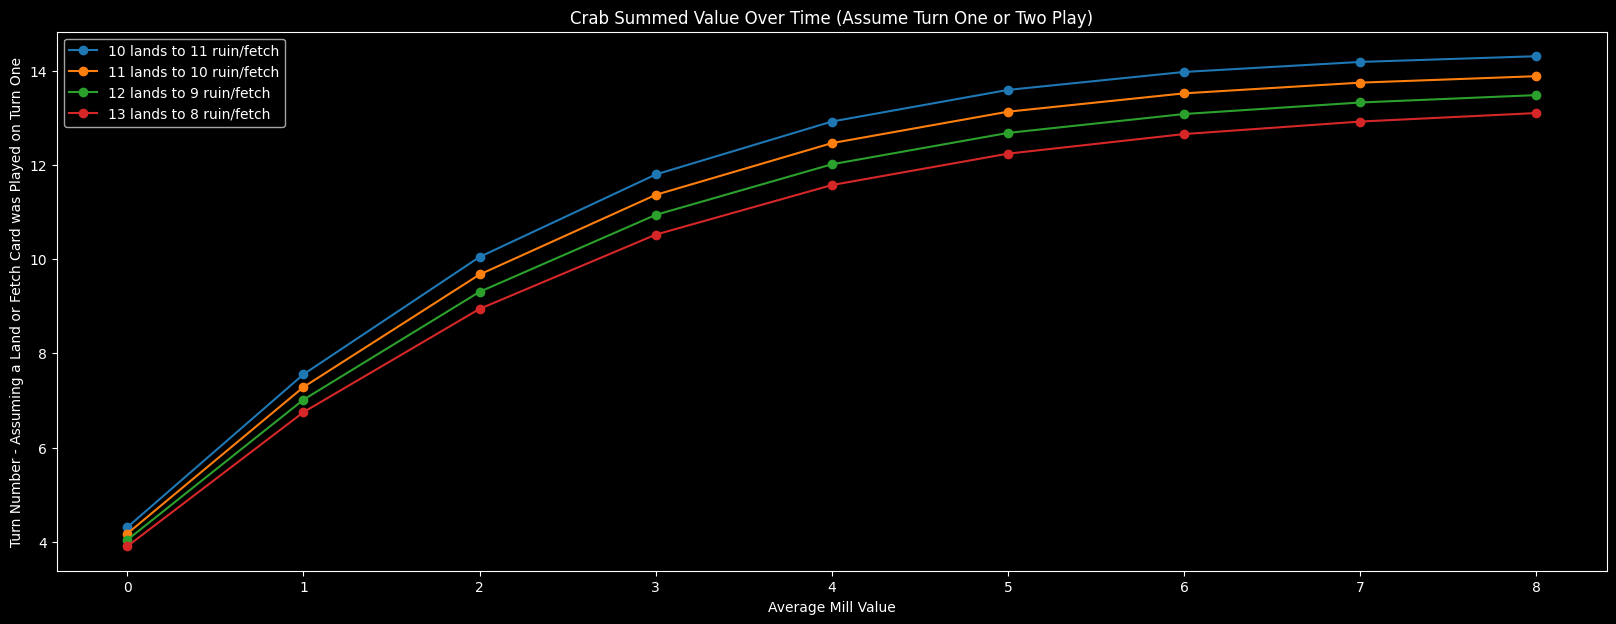

In [69]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)

for i in range(len(crab_line_on_play)):
    ax.plot([i for i in range(len(crab_summed_on_play[i]))], crab_summed_on_play[i], marker="o", color=colors_list[i], label=f"{land_cards[i]} lands to {fetch_ruin[i]} ruin/fetch")

plt.title("Crab Summed Value Over Time (Assume Turn One or Two Play)")

plt.xlabel("Average Mill Value")
plt.ylabel("Turn Number - Assuming a Land or Fetch Card was Played on Turn One")

plt.xticks([i for i in range(len(crab_summed_on_play[i]))])

plt.legend()

plt.show()

## Conclusions

The crabs have greatly diminished over time in this experiment. While it still holds true that these crabs have a great return on the value of one mana, while providing a blocker, after turn four, the value of the crabs in relation to cards milled falls off. This also assumes on average, allowing the player to make better decisions in relation to their crabs played. If a land is played every turn, it makes more sense to play the crabs. However, if there are no lands in hand, it makes sense that the crabs hold less value and other plays should be explored.

if multiple crabs are played, the return on each land is amplified, and can easily win the game. Therefore, if more crabs are dropped early, the larger the impact had. However, I would think that it is safe to say that a single crab needs to survive two turns with land drops to make good value on average. Fetch/Ruin Land cards are worth double normal lands, and are clearly much better, resulting in higher average crab value if present in greater quantities.

There are three assumptions that need to be noted before going forward.
* This experiment assumes that all lands that are not fetch/ruin lands are able to fetched, which is not true. Many lands are not able to be retrieved in this way, which would result in fewer triggers and more times in which fetch/ruin lands are worth 3 milled cards rather than 6. However, this can be offset by certain cards.
* I do not assume that land cards such *Oboro, Palace in the Clouds* is played, which allow a land to played when one isn't drawn. This card in particular can be returned to hand and then played, allowing any crabs on the field to not miss a trigger.
* This experiment also does not assume that the deck is playing any draw spells, such as *Preordain* or *Visions of Beyond*. These cards would make the deck much more likely to find lands, allowing less land drops to be missed. This could then result in more crab triggers.

![Oboro, Palace in the Clouds](http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=74206&type=card)
![Preordain](http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=405347&type=card)
![Visions of Beyond](http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=220226&type=card)


# Mill Value per CMC

Here is the moment of truth. Generally, we want a curve for the cards in our deck. If we wanted straight line between each mana cost of cards, Glimpse the Unthinkable would be widely played, milling 10 cards for two mana value. While this seems amazing (it has more card per value than Fractured Sanity and Tasha's Hideous Laughter on average), card advantage makes this a lackluster card comparatively. This card was a powerhouse for this deck, until the previous mentioned three mana costing cards were made. To fully understand why this is, card advantage needs to be discussed.

### Card Advantage

Card advantage comes in multiple forms: increasing cards at your disposal, decreasing the cards at the enemies disposal. In the first case, card draw is the biggest advantage to this. With more cards in hand, you have more options to play and more answers that further your gameplan or prevent your opponent from achieving their gameplan. When Visions of Beyond draws three cards, it provides tremendous card advantage by increasing the cards in your hand by two! Preordain does not provide card advantage, but it is a great card because it allows for you to filter the cards at the top of your deck when finding a suitable replacement.

The second case comes from removal, discard, and counters. In many cases, there is no card advantage because these effects tend to be one-for-one, or one card played to remove one resources. Cards such as Fatal Push can destroy a creature while Field of Ruin can destroy one non-basic land. These are one for one trades that create equal card advantage. However, there are cards that can provide more. If I can play one card to destroy all of my opponents creatures (i.e. Wrath of God, Damnation) or force my opponent to discard while creating a threat (i.e. Grief, Archon of Cruelty), These are cases where there is card advantage gained.

Card advantage can be complicated, but by tallying up the cards at each players disposal and the threat that they pose, you can get a rough idea of card advantage. More card advantage is a good thing, as it allows for more answers.

### Card Advantage and Mill

If you were to play Fractured Sanity, milling fourteen cards, one would assume that this is great card advantage. One card was played, getting rid of fourteen of the opponent's cards!

Unfortunately, this is not card advantage. The one card got rid of fourteen cards that could have been a resource for the opponent, rather than cards that are a resource at that moment. Fractured Sanity, Hedron Crab, Ruin Crab, Tasha's Hideous Laughter, etc. do not influence the resources which the opponent has through hand disruption, land destruction, or creature removal. Instead, the opponent still has all of their resources, while you are down one card in hand. As a matter of fact, some decks such as Living End want more cards in the graveyard, which means that you are providing more card advantage to your opponent's deck! This makes Mill tricky to play, because by furthering your gameplan of removing all cards from the opponent's deck, you are probably going to provide the opponent with card advantage.

This means that all mill cards in your deck must provide as much mill value as possible. Fractured Sanity and Tasha's provide great value not because they are mil fourteen for three mana, but because they mill fourteen for one card played at a resonable price.

Mill decks also employ cards that benefit from milling your opponent. Cards such as Surgical Extraction become more potent when you have more options, and cards such as Drown in the Loch get past their balanced downside through mill as well. Visions of Beyond and Drown in the Loch both are incredible value once activated, and at a cheap mana value, all thanks to mill.

### So what is the average CMC per milled card?

I personally don't think this number matters except for the idea of milling more cards with achievable mana value and additional value. Hedron Crab and Ruin Crab can be played on turn two to guarantee at least one crab trigger of value, while eating up opponent removal spells and being a blocker. Fractured Sanity has a cycle effect which allows it to replace itself in hand at lower mill value, in an attempt to find something else while still providing value. Tasha's Hideous Laughter's variability can be a blessing and a curse, but the exile effect can also hurt the game plan for some decks. Even Jace, the Perfected Mind, which provides lower mill value per CMC (15 for 4 mana, or 9 for 3 mana) is amazing because it has other effects attached to it, too (an effect similar to Visions of Beyond and the ability to protect itself).

Good mill cards either mill as much as possible, or provide additional value. This is why Glimpse the Unthinkable is no longer played, and why Sanity Grinding and Mind Funeral are bad cards. Mill needs as much value as possible out of every card it plays.